# Face Mask Classification


---

## Load dataset from kaggle

In [1]:
import os
os.environ['KAGGLE_USERNAME']= 'username'
os.environ['KAGGLE_KEY'] = 'user key'

In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

 96% 156M/163M [00:01<00:00, 109MB/s]
100% 163M/163M [00:01<00:00, 120MB/s]


In [3]:
import zipfile

local_zip = '/content/face-mask-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
path = '/content/data'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

## Labeling dataset

In [5]:
import pandas as pd

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3828
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7553 entries, 0 to 7552
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       7553 non-null   object
 1   file_name  7553 non-null   object
 2   tag        7553 non-null   object
dtypes: object(3)
memory usage: 177.1+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Category')

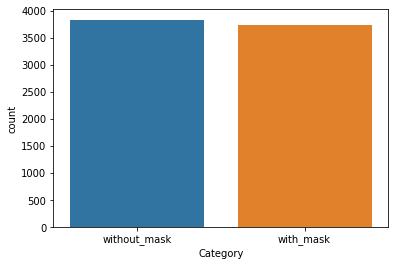

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df.tag)
plt.xlabel('Category')

In [ ]:
df

,path,file_name,tag
0,/content/data/without_mask/without_mask_351.jpg,without_mask_351.jpg,without_mask
1,/content/data/without_mask/without_mask_2139.jpg,without_mask_2139.jpg,without_mask
2,/content/data/without_mask/without_mask_1387.jpg,without_mask_1387.jpg,without_mask
3,/content/data/without_mask/without_mask_1115.jpg,without_mask_1115.jpg,without_mask
4,/content/data/without_mask/without_mask_2520.jpg,without_mask_2520.jpg,without_mask
...,...,...,...
7548,/content/data/with_mask/with_mask_2982.jpg,with_mask_2982.jpg,with_mask
7549,/content/data/with_mask/with_mask_508.jpg,with_mask_508.jpg,with_mask
7550,/content/data/with_mask/with_mask_664.jpg,with_mask_664.jpg,with_mask
7551,/content/data/with_mask/with_mask_2241.jpg,with_mask_2241.jpg,with_mask


## Split dataset

In [7]:
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.2, random_state=1
)

In [8]:
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test-set'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train-set'
})

In [9]:
print('train size', len(df_train))
print('test size', len(df_test))

train size 6042
test size 1511


In [10]:
df_all = df_train.append([df_test]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set        tag         
test-set   with_mask        744
           without_mask     767
train-set  with_mask       2981
           without_mask    3061
dtype: int64 




,path,tag,set
5421,/content/data/without_mask/without_mask_2642.jpg,without_mask,train-set
5726,/content/data/with_mask/with_mask_386.jpg,with_mask,train-set
1399,/content/data/without_mask/without_mask_1212.jpg,without_mask,train-set
7124,/content/data/with_mask/with_mask_3613.jpg,with_mask,test-set


## Move Dataset

In [11]:
import shutil
from tqdm.notebook import tqdm as tq

In [12]:
datasource_path = '/content/data'
dataset_path = '/content/dataset'

In [13]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

## Define Directory

In [14]:
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train-set')
test_dir = os.path.join(base_dir, 'test-set')

In [15]:
os.listdir(train_dir)

['without_mask', 'with_mask']

In [16]:
os.listdir(test_dir)

['without_mask', 'with_mask']

In [17]:
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')

## Image Augmentation

In [18]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.4.0


In [94]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 16,
    class_mode = 'binary'
)

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


## Build CNN Model using Transfer Learning MobileNetV2

In [95]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [98]:
model = tf.keras.models.Sequential([
    MobileNetV2(weights = "imagenet", include_top= False, input_tensor = Input(shape=(224,224,3))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_16 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               16056576  
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)               

In [99]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print('Akurasi mencapai 97%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [100]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=1e-4)

model.compile(
    optimizer = opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 50,
    validation_data = test_generator,
    validation_steps = 3,
    callbacks = [callbacks]
)

Epoch 1/50
20/20 [==============================] - 10s 304ms/step - loss: 1.2081 - accuracy: 0.5843 - val_loss: 0.5972 - val_accuracy: 0.7500
Epoch 2/50
20/20 [==============================] - 5s 260ms/step - loss: 0.8024 - accuracy: 0.7474 - val_loss: 0.3080 - val_accuracy: 0.8333
Epoch 3/50
20/20 [==============================] - 5s 268ms/step - loss: 0.5053 - accuracy: 0.8225 - val_loss: 0.3345 - val_accuracy: 0.9375
Epoch 4/50
20/20 [==============================] - 5s 270ms/step - loss: 0.3676 - accuracy: 0.8553 - val_loss: 0.3872 - val_accuracy: 0.8958
Epoch 5/50
20/20 [==============================] - 5s 254ms/step - loss: 0.1273 - accuracy: 0.9498 - val_loss: 0.1221 - val_accuracy: 0.9167
Epoch 6/50
20/20 [==============================] - 6s 277ms/step - loss: 0.2418 - accuracy: 0.8913 - val_loss: 0.3061 - val_accuracy: 0.8750
Epoch 7/50
20/20 [==============================] - 5s 271ms/step - loss: 0.2029 - accuracy: 0.9303 - val_loss: 0.2080 - val_accuracy: 0.9375
Epoch

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 5s 273ms/step - loss: 0.1923 - accuracy: 0.9399 - val_loss: 0.2013 - val_accuracy: 0.8958
Epoch 9/50
20/20 [==============================] - 5s 272ms/step - loss: 0.1922 - accuracy: 0.9359 - val_loss: 0.1456 - val_accuracy: 0.9375
Epoch 10/50
20/20 [==============================] - 5s 261ms/step - loss: 0.2138 - accuracy: 0.9279 - val_loss: 0.0701 - val_accuracy: 0.9583
Epoch 11/50
20/20 [==============================] - 5s 260ms/step - loss: 0.1084 - accuracy: 0.9684 - val_loss: 0.2696 - val_accuracy: 0.9583
Akurasi mencapai 97%, proses training dihentikan!


## Plot Train and Test

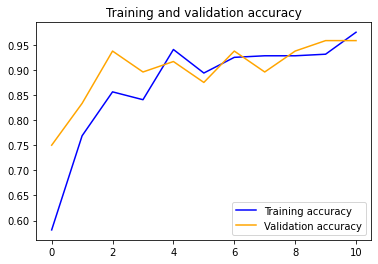

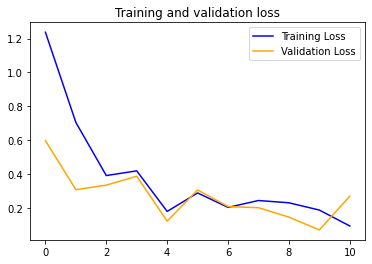

In [102]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict

Saving IBVA5414.JPG to IBVA5414 (3).JPG


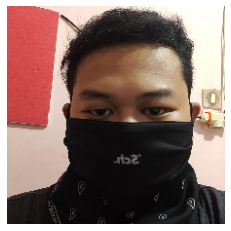

Not Wearing Masker


In [103]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

Saving CZZR2628.JPG to CZZR2628.JPG


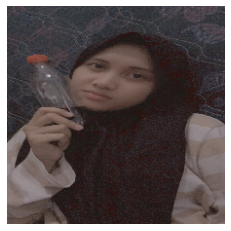

Not Wearing Masker


In [104]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

## Evaluasi

Dikarenakan model tidak bisa memprediksi dengan benar, maka dibuat kembali model dengan custom CNN.

## CNN Build

In [112]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 22, 22, 256)       295168    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 30976)           

In [113]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print('Akurasi mencapai 97%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [114]:
model_cnn.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 100,
    validation_data = test_generator,
    validation_steps = 3,
    callbacks = [callbacks]
)

Epoch 1/100
20/20 [==============================] - 6s 256ms/step - loss: 0.7392 - accuracy: 0.5132 - val_loss: 0.7009 - val_accuracy: 0.4375
Epoch 2/100
20/20 [==============================] - 5s 246ms/step - loss: 0.7072 - accuracy: 0.4713 - val_loss: 0.6936 - val_accuracy: 0.4583
Epoch 3/100
20/20 [==============================] - 5s 232ms/step - loss: 0.6906 - accuracy: 0.5894 - val_loss: 0.6660 - val_accuracy: 0.7500
Epoch 4/100
20/20 [==============================] - 5s 230ms/step - loss: 0.6707 - accuracy: 0.5749 - val_loss: 0.6137 - val_accuracy: 0.7708
Epoch 5/100
20/20 [==============================] - 5s 251ms/step - loss: 0.6129 - accuracy: 0.6966 - val_loss: 0.4947 - val_accuracy: 0.8125
Epoch 6/100
20/20 [==============================] - 5s 234ms/step - loss: 0.5385 - accuracy: 0.7364 - val_loss: 0.4771 - val_accuracy: 0.7292
Epoch 7/100
20/20 [==============================] - 5s 238ms/step - loss: 0.6023 - accuracy: 0.7093 - val_loss: 0.4317 - val_accuracy: 0.8125

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 5s 250ms/step - loss: 0.3927 - accuracy: 0.8474 - val_loss: 0.6328 - val_accuracy: 0.7292
Epoch 16/100
20/20 [==============================] - 5s 231ms/step - loss: 0.4600 - accuracy: 0.8025 - val_loss: 0.2913 - val_accuracy: 0.8958
Epoch 17/100
20/20 [==============================] - 5s 227ms/step - loss: 0.3334 - accuracy: 0.8581 - val_loss: 0.3984 - val_accuracy: 0.8750
Epoch 18/100
20/20 [==============================] - 5s 237ms/step - loss: 0.3164 - accuracy: 0.8840 - val_loss: 0.3995 - val_accuracy: 0.8542
Epoch 19/100
20/20 [==============================] - 5s 241ms/step - loss: 0.3890 - accuracy: 0.8490 - val_loss: 0.2544 - val_accuracy: 0.8958
Epoch 20/100
20/20 [==============================] - 5s 237ms/step - loss: 0.4028 - accuracy: 0.8350 - val_loss: 0.3720 - val_accuracy: 0.8542
Epoch 21/100
20/20 [==============================] - 5s 238ms/step - loss: 0.3772 - accuracy: 0.8668 - val_loss: 0.4293 - val_accuracy: 0.8333
Epoch

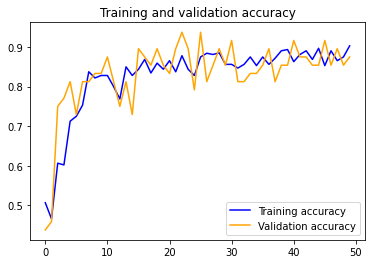

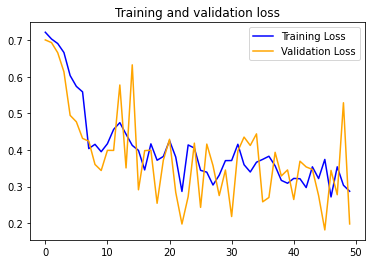

In [115]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving MHHH7915.JPG to MHHH7915 (2).JPG


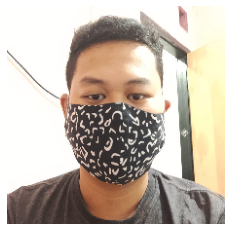

Wearing Masker


In [116]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model_cnn.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

Saving IMG_0360.JPG to IMG_0360 (1).JPG


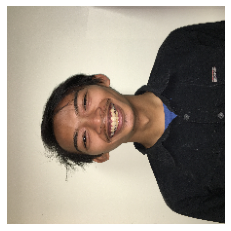

Not Wearing Masker


In [117]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path,target_size=(224,224))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = np.array(img, dtype='float')
  img = img.reshape(1, 224, 224, 3)
  prediksi = model_cnn.predict(img)
  idx = prediksi[0][0]
  if (idx):
      print("Not Wearing Masker")
  else:
      print("Wearing Masker")

## Save Model

In [118]:
model_cnn.save("/content/model_cnn.h5")